In [1]:
# default_exp layers

# Layers

> Pytorch model layers

In [2]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [3]:
# export
from mrl.imports import *
from mrl.torch_imports import *

In [4]:
# export

class Linear(nn.Module):
    def __init__(self, d_in, d_out, act=True, bn=False, dropout=0.):
        super().__init__()
        
        layers = [nn.Linear(d_in, d_out)]
        
        if bn:
            layers.append(nn.BatchNorm1d(d_out))
            
        if act:
            layers.append(nn.ReLU())
            
        if dropout>0.:
            layers.append(nn.Dropout(p=dropout))
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

In [5]:
# export

class LSTMBase(nn.Module):
    def __init__(self, d_vocab, d_embedding, d_hidden, n_layers, pad_idx, 
                 lstm_drop=0.):
        super().__init__()
        
        self.d_vocab = d_vocab
        self.d_embedding = d_embedding
        self.d_hidden = d_hidden
        self.n_layers = n_layers
        self.pad_idx = pad_idx
        
        self.embedding = nn.Embedding(d_vocab, d_embedding, padding_idx=pad_idx)
        
        self.lstms = []
        
        for i in range(n_layers):
            input_size = d_embedding if i==0 else d_hidden
            output_size = d_embedding if i==n_layers-1 else d_hidden
                
            lstm = nn.LSTM(input_size, output_size, 1, batch_first=True, dropout=lstm_drop)
            self.lstms.append(lstm)
            
        self.lstms = nn.ModuleList(self.lstms)
                
    def forward(self, x):
        x = self.embedding(x)
        
        hiddens = []
        for i, lstm in enumerate(self.lstms):
            x, (h,c) = lstm(x)
            hiddens.append((h.detach(), c.detach()))
        
        self.last_hiddens = hiddens

        return x
    
# class LMHead(nn.Module):
#     def __init__(self, d_in, d_out):
#         super().__init__()
        
#         self.layer = nn.Linear(d_in, d_out)
        
#     def forward(self, x):
#         return self.layer(x)

In [6]:
from mrl.dataloaders import *

In [7]:
# df = pd.read_csv('files/smiles.csv')
df = next(pd.read_csv('../../ZINC_shards_shuffled/shard_0.csv', chunksize=10000000))

In [8]:
df = df[df.smiles.map(lambda x: len(x))<100]

In [9]:
df.head()

,smiles,zinc_id,inchikey,mwt,logp,reactive,purchasable,tranche_name,features
0,O=C(NCc1ccc(Br)cc1F)C(=O)NCC1(Cc2ccccc2)CC1,ZINC000807669219,RPRBOANYNLBELV-UHFFFAOYSA-N,419.294,3.344,0.0,20.0,HGAD,NaN
1,C[C@@H](NC(=O)[C@@H]1CCc2nccn2C1)C1CN(Cc2cncn2...,ZINC000969991574,GDQMPQCGXNSNHF-ZIAGYGMSSA-N,342.447,0.816,0.0,20.0,ECAD,NaN
2,C[C@@H](c1ccccc1F)N(C)c1nnc(CC(C)(C)C)n1CCNS(=...,ZINC001541788850,ALRPTKPQPMHISQ-INIZCTEOSA-N,478.594,3.311,0.0,20.0,JGAD,NaN
3,O=C(Cc1ccccc1Cl)N1CC(NC(=O)[C@@H]2C[C@@H]3CCCC...,ZINC000997656351,BFXLNUTXWTYLSO-RRQGHBQHSA-N,360.885,3.036,0.0,20.0,FGAD,NaN
4,Cn1[nH]c(CN2C[C@H]3CC[C@H]2CN3C(=O)[C@H]2CCNC(...,ZINC000971263820,JZUXMQSAMSOURF-SDDRHHMPSA-N,348.407,-1.190,0.0,20.0,EAAD,NaN


In [10]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

In [11]:
len(vocab.itos)

42

In [12]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [13]:
train_data = df.sample(frac=0.98)
valid_data = df[~(df.index.isin(train_data.index))]

In [14]:
train_ds = TextDataset(train_data.smiles.values, vocab)
valid_ds = TextDataset(valid_data.smiles.values, vocab)

In [15]:
train_dl = train_ds.dataloader(96, num_workers=0)
valid_dl = valid_ds.dataloader(96, num_workers=0, shuffle=False)

In [16]:
len(train_dl)

102077

In [17]:
class LSTMLM(nn.Module):
    def __init__(self, d_vocab, d_embedding, d_hidden, n_layers, pad_idx, lstm_drop=0.):
        super().__init__()
        self.base = LSTMBase(d_vocab, d_embedding, d_hidden, n_layers, pad_idx, lstm_drop)
        self.head = Linear(d_embedding, d_vocab, act=False, bn=False, dropout=0.)
        
    def forward(self, x):
        x = self.base(x)
        x = self.head(x)
        return x

In [18]:
from fastai.text.all import *

In [19]:
model = LSTMLM(len(vocab.itos), 256, 1024, 3, vocab.stoi['pad'])
# encoder = AWD_LSTM(len(vocab.itos), 256, 1024, 3, vocab.stoi['pad'])
# decoder = LinearDecoder(len(vocab.itos), 256, 0., tie_encoder=False, bias=True)
# model = SequentialRNN(encoder, decoder)

In [20]:
from fastai.vision.all import *

In [21]:
dl = DataLoaders(train_dl, valid_dl)

In [22]:
# learn = Learner(dl, model, loss_func=CrossEntropyLossFlat(), cbs=[ModelResetter(), RNNCallback()])
learn = Learner(dl, model, loss_func=CrossEntropyLossFlat())

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0012022644514217973)

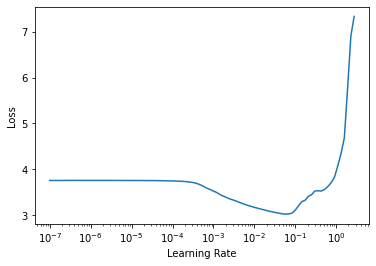

In [23]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,time
0,0.317389,0.317360,4:06:27
1,0.300273,0.300688,4:08:10


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [24]:
learn.save('lstm1')

Path('models/lstm1.pth')

In [25]:
torch.backends.cudnn.enabled

True

In [29]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,time
0,0.356515,0.356407,12:51
1,0.331074,0.332720,12:55
2,0.312755,0.316965,12:56
3,0.301957,0.311658,12:30


In [19]:
model.cuda();

In [20]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5)
sched = torch.optim.lr_scheduler.OneCycleLR(opt, 3e-3, total_steps=len(train_dl)*4)

In [23]:
loss_fn = nn.CrossEntropyLoss()
losses = []
lrs = []
epochs = 4

for epoch in range(epochs):
    print(epoch)
    for i, batch in enumerate(train_dl):
        if i%400==0 and i>0:
            print(torch.tensor(losses[-50:]).mean())
        x,y = batch
        x = x.cuda()
        y = y.cuda()

        out = model(x)
        opt.zero_grad()
        loss = loss_fn(out.reshape(-1,out.shape[-1]), y.reshape(-1))
        loss.backward()
        opt.step()
        sched.step()
        losses.append(loss.detach().cpu())
        lrs.append(opt.defaults['lr'])
        
    with torch.no_grad():
        valid_losses = []
        for i, batch in enumerate(valid_dl):
            x,y = batch
            x = x.cuda()
            y = y.cuda()
            out = model(x)
            loss = loss_fn(out.reshape(-1,out.shape[-1]), y.reshape(-1))
            valid_losses.append(loss.detach().cpu())
            
            
        valid_loss = torch.tensor(valid_losses).mean()
        print(f'Valid loss: {valid_loss}')

0
tensor(1.7611)
tensor(1.4714)
tensor(1.0725)
tensor(0.8579)
tensor(0.7714)
tensor(0.6974)
tensor(0.6446)
tensor(0.6038)
tensor(0.5761)
tensor(0.5557)
tensor(0.5363)
tensor(0.5197)
tensor(0.4988)
tensor(0.4862)
tensor(0.4780)
tensor(0.4592)
tensor(0.4567)
tensor(0.4506)
tensor(0.4499)
tensor(0.4467)
tensor(0.4278)
tensor(0.4210)
tensor(0.4169)
tensor(0.4187)
tensor(0.4169)
tensor(0.4191)
tensor(0.4122)
tensor(0.4050)
tensor(0.4041)
tensor(0.4046)
tensor(0.3974)
tensor(0.4041)
tensor(0.3977)
tensor(0.3945)
tensor(0.3891)
tensor(0.3880)
tensor(0.3958)
tensor(0.3902)
tensor(0.3875)
tensor(0.3820)
tensor(0.3847)
tensor(0.3835)
tensor(0.3829)
tensor(0.3711)
tensor(0.3737)
tensor(0.3786)
tensor(0.3775)
tensor(0.3751)
tensor(0.3789)
tensor(0.3665)
tensor(0.3752)
tensor(0.3796)
tensor(0.3762)
tensor(0.3712)
tensor(0.3763)
tensor(0.3688)
tensor(0.3646)
tensor(0.3705)
tensor(0.3683)
tensor(0.3676)
tensor(0.3674)
tensor(0.3699)
tensor(0.3675)
tensor(0.3698)
tensor(0.3696)
tensor(0.3668)
tensor(0

In [44]:
bs = 12

preds = idxs = torch.tensor([vocab.stoi['bos']]*bs).long().cuda().unsqueeze(-1)

hiddens = []
for l in range(model.base.n_layers):
    if l==model.base.n_layers-1:
        d_hidden = model.base.d_embedding
    else:
        d_hidden = model.base.d_hidden
        
    h = torch.zeros((1,bs, d_hidden)).cuda()
    c = torch.zeros((1,bs, d_hidden)).cuda()
    hiddens.append((h,c))

with torch.no_grad():
    for i in range(80):
        x = model.base.embedding(idxs)
        new_hidden = []
        for i, lstm in enumerate(model.base.lstms):
            x, (h,c) = lstm(x, hiddens[i])
            new_hidden.append((h.detach(), c.detach()))
            
        hiddens = new_hidden
            
        x = model.head(x)
        log_probs = F.log_softmax(x, -1).squeeze(1)
        idxs = torch.multinomial(log_probs.exp(), 1)
#         idxs = x.argmax(-1)
        preds = torch.cat([preds, idxs], -1)

In [45]:
preds[0]

tensor([ 0, 22, 22, 22, 26, 22,  5, 19, 27,  6, 22, 22, 36, 11, 33,  5, 22, 27,
        33, 12, 33, 33, 33,  5, 22,  6, 33,  5, 22,  6, 33, 12,  6, 36, 36, 33,
        11, 26, 11, 22, 22, 30, 22, 20, 24, 32,  5, 30, 22, 20, 20, 24, 32, 12,
        22, 22, 27, 22, 12,  6, 22, 11,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2], device='cuda:0')

In [46]:
vocab.reconstruct(preds[0])

'CCCNC(=O)CCn1c(COc2ccc(C)c(C)c2)nnc1N1CC[C@H]([C@@H]2CCOC2)C1'

In [31]:
x,y = next(iter(valid_dl))

In [32]:
x.shape

torch.Size([96, 75])

In [33]:
x.device

device(type='cpu')

In [36]:
with torch.no_grad():
    p = learn.model(x.cuda())

In [37]:
p.shape

torch.Size([96, 75, 42])

In [38]:
probs = F.softmax(p, -1)

In [40]:
probs.argmax(-1)[0]

tensor([22, 22,  5,  5, 22, 22,  6, 26, 19, 27,  6, 26, 22, 22,  5, 19, 27,  6,
        33, 11, 33, 36, 24, 32, 33, 12, 22, 33, 12, 33, 33, 33, 33, 33, 22, 22,
         6, 33, 12,  6, 36, 33, 11, 22,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2], device='cuda:0')

In [41]:
y[0]

tensor([22, 22, 26,  5, 22, 22, 22,  5, 19, 27,  6, 27,  6, 22,  5, 19, 27,  6,
        33, 11, 30, 36, 24, 32, 33,  5,  8, 33, 12, 33, 33, 33, 33,  5, 27, 22,
         6, 33, 12,  6, 36, 33, 11, 22,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2])

In [43]:
probs.argmax(-1)[0]==y[0].cuda()

tensor([ True,  True, False,  True,  True,  True, False, False,  True,  True,
         True, False, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True], device='cuda:0')

In [47]:
# hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_chem.ipynb.
Converted 02_template.filters.ipynb.
Converted 03_template.template.ipynb.
Converted 04_template.blocks.ipynb.
Converted 05_torch_core.ipynb.
Converted 06_layers.ipynb.
Converted 07_dataloaders.ipynb.
Converted index.ipynb.
Converted template.overview.ipynb.
Converted tutorials.ipynb.
Converted tutorials.structure_enumeration.ipynb.
Converted tutorials.template.advanced.ipynb.
Converted tutorials.template.beginner.ipynb.
Converted tutorials.template.intermediate.ipynb.
